#  Divisas (FX) 
Estrategia: Medias móviles con filtro HP
---

Juan Sebastián Rojas Rodríguez | VIP Alliance | Trader Master Bolsa

## References:
- Hodrick, Robert J. and E.C. Prescott (1980) "Postwar U.S. Business Cycles: an Empirical Investigation"; mss. Pittsburgh: Carnegie-Mellon University; Discussion Papers 451, Northwestern University.

## Definición

El filtro de Hodrick-Prescott es un método para extraer el componente secular o de tendencia de una serie temporal.

Supongamos que se tiene una muestra de $T$ observaciones de una variable aletoria $Y_t$:

\begin{equation*}
    \{y_1, y_2,\dots, y_T \}.
\end{equation*}

$Y_t$ se puede descomponer en dos componentes: una de creciemiento (la tendencia) $s_t$ y una ciclica $c_t$:

\begin{equation*}
    y_t = s_t + c_t    
\end{equation*}

Formalmente la componente tendencial se define como la solución al siguiente problema (función de perdida cuadratica) de optimización:

\begin{align*}
s_i^{HP} &=   argmin_{s_1,\dots,s_T}\left\{\sum_{t=1}^{T}\left(y_t-s_t\right)^2 +  \lambda \sum_{t=2}^{T-1}\left[\left(s_{t+1}-s_t\right) - \left(s_t-s_{t-1}\right)  \right]^2    \right\}\\ \\
         &= argmin_{s_1,\dots,s_T}\left\{\sum_{t=1}^{T}\left(y_t-s_t\right)^2 +  \lambda \sum_{t=2}^{T-1}\left(s_{t+1}-2s_t + s_{t-1}\right)^2 \right\}
\end{align*}

Para efectos computacionales, esta expresión se puede reescribir en forma matricial teniendo en cuenta los siguientes elementos:

\begin{equation*}
Y = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_T
\end{bmatrix}
\qquad
S = \begin{bmatrix}
s_1 \\
s_2 \\
\vdots \\
s_T
\end{bmatrix}
\end{equation*}


\begin{equation*}
A_{T-2\times T} =
\begin{bmatrix}
1 & -2 & 1 & 0 & \dots & 0 & 0 & 0 & 0 \\
0 & 1 & -2 & 1 & \dots & 0 & 0 & 0 & 0 \\
&  & \vdots &  & \ddots &  & \vdots &  &  \\
0 & 0 & 0 & 0 & \dots & 0 & 1 & -2 & 1
\end{bmatrix}
\end{equation*}

Con lo cual se tiene un problema matricial con la siguiente expresión:

\begin{align*}
    s_i^{HP} &= argmin_{S}\left\{(Y-S)'(Y-S) +  \lambda (AS)'(AS) \right\} \\
             &= argmin_{S}\left\{Y'Y - 2Y'S +  S'(I + \lambda A'A)S \right\}\\
 \Rightarrow & - 2Y + 2\left(I + \lambda A'A\right)S = 0
\end{align*}

Finalemente el filtro HP resulta en las siguientes dos componentes:

\begin{align*}
S^{HP}                 &= \left(I + \lambda A'A\right)^{-1}Y \tag{tendencia} \\
C^{HP} \equiv Y-S^{HP} &= \left[I - \left(I + \lambda A'A\right)^{-1}\right]Y \tag{ciclo}
\end{align*}

### Parámetro de suavizado $\lambda$

El parámetro de suavizado $\lambda$ no tiene un método fundamental para fijar su valor. En algunas ocacioness se establece como $\lambda = 100 \times n^{2}$ donde $n$ es la frecuencia de datos medida en base anual. Por lo tanto, para datos anuales $n=1$, para datos mensuales $n=12$, para datos trimestrales $n=4$ y para datos diarios $n=252$.

<span style='color:Red'> IMPORTANTE:  </span>
 Para esta estrategia es recomendable usar datos mensuales, en intervalos que abarquen varios años.

In [10]:
!pip install -r requirements.txt

In [11]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import yfinance as yf
import version_information


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Forex data

In [12]:
ticker = "EURUSD=X"
eurusd = yf.download(ticker, period="20y", interval="1mo")

[*********************100%%**********************]  1 of 1 completed


In [13]:
eurusd.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-01,1.069519,1.101115,1.066416,1.086803,1.086803,0
2023-07-01,1.091822,1.127574,1.083435,1.102426,1.102426,0
2023-08-01,1.099759,1.105840,1.076670,1.093255,1.093255,0
2023-09-01,1.084410,1.088080,1.049186,1.058761,1.058761,0
2023-10-01,1.058761,1.059816,1.044987,1.055075,1.055075,0


In [14]:
eurusd.shape

(239, 6)

In [15]:
def HP_filter(y, lamb: float):
    """
    Hodrick-Prescott Filter
    Parameters
    ----------
    y: Series
        Contains price data.
    lamb: float
        As rule of thumb, lambda is choosen about data frecuency
        as follows:
        annual: 100
        quaterly: 1600
        monthly: 14400
    """
    Y = y.values
    T = len(Y)
    A = np.zeros((T-2, T))
    for i in range(T-2):
        A[i, i:i+3] = 1, -2, 1
        
    I = np.identity(T)
    B = I + lamb*A.T.dot(A)
    # trend = (linalg.inv(B).dot(Y))      # slow 
    trend = np.linalg.solve(B, Y)         # fast
    cycle = Y - trend
    
    return pd.DataFrame(
        {'original': Y,
         'trend': trend,
         'cycle': cycle
        },
        index=y.index)

In [16]:
price_filter = HP_filter(eurusd["Close"], lamb=14440)

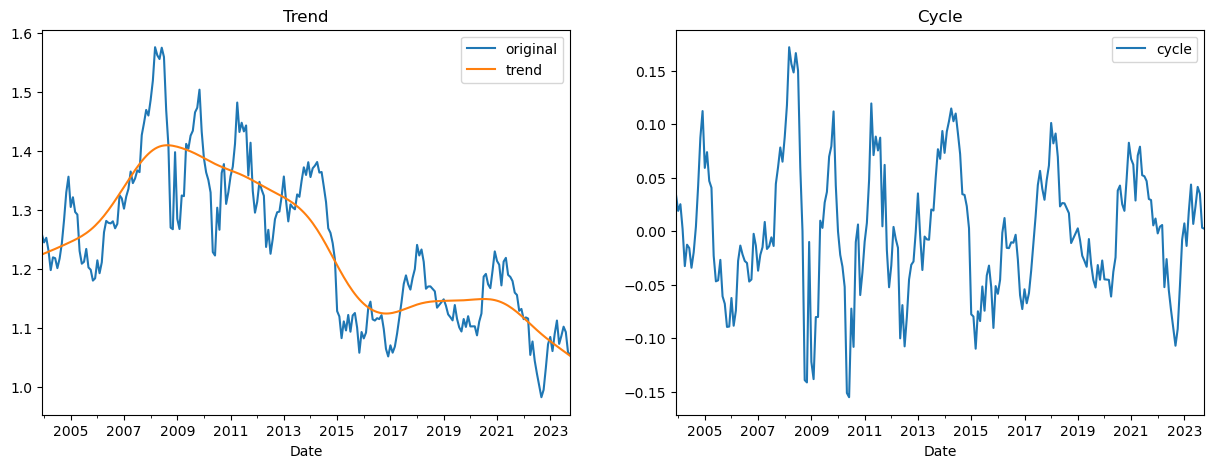

In [17]:
figure, axes = plt.subplots(ncols=2, figsize=(15,5))
price_filter[['original', 'trend']].plot(ax=axes[0])
price_filter[['cycle']].plot(ax=axes[1])
axes[0].set_title("Trend")
axes[1].set_title("Cycle")
plt.show()

In [18]:
price_filter.head()

,original,trend,cycle
Date,,,
2003-12-01,1.259002,1.224729,0.034273
2004-01-01,1.245206,1.226286,0.018920
2004-02-01,1.253007,1.227844,0.025163
2004-03-01,1.231300,1.229409,0.001890
2004-04-01,1.198294,1.230986,-0.032692


## Strategy

In [19]:
column_name = "trend"
df_final = price_filter.copy()
df_final["SMA1"] = df_final[column_name].rolling(10).mean()
df_final["SMA2"] = df_final[column_name].rolling(20).mean()
df_final.dropna(axis=0, inplace=True)

In [20]:
def strategy(data):
    """
    Toma de desición de compra o venta en función de dos medias
    moviles simples.
    La temporalidad para SMA1 es menor que para SMA2.
    Parameters
    ----------
    data: DataFrame
        DataFrame containing SMAs values for two different timeframes.
    """
    df = data.copy()
    df["Signal"] = np.where(df["SMA1"] > df["SMA2"],
                            1, 0)
    df["Signal"] = np.where(df["SMA1"] < df["SMA2"],
                            -1, df["Signal"])
    
    return df

In [21]:
strategy_df = strategy(df_final)

In [22]:
entry = strategy_df.Signal.diff()
entry[0] = np.where(strategy_df["Signal"][0] == 1, 2, 0)
entry[0] = np.where(strategy_df["Signal"][0] == -1, -2, entry[0])
strategy_df["Entry"] = entry

In [23]:
strategy_df.Entry.unique()

array([ 2.,  0., -2.])

## Plot

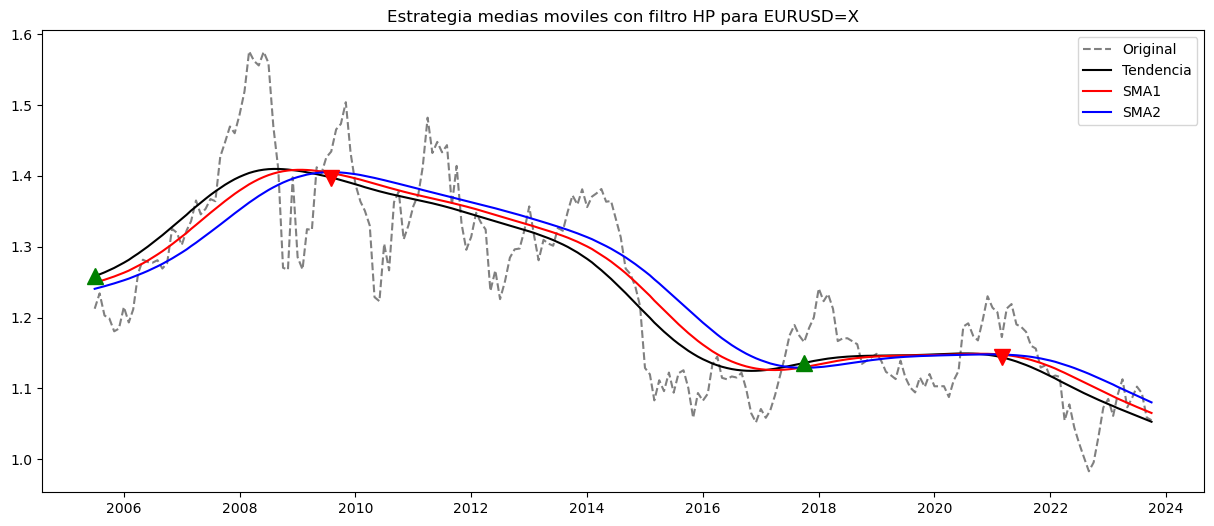

In [24]:
plt.figure(figsize=(15,6))
plt.plot(strategy_df["original"], label="Original", color="gray", linestyle="--")
plt.plot(strategy_df["trend"], label="Tendencia", color="k")
plt.plot(strategy_df["SMA1"], label="SMA1", color="r")
plt.plot(strategy_df["SMA2"], label="SMA2", color="b")

plt.plot(strategy_df.loc[strategy_df["Entry"] == -2].index, strategy_df["trend"][strategy_df["Entry"] == -2],
         'v', color='r', markersize=12)
plt.plot(strategy_df.loc[strategy_df["Entry"] == 2].index, strategy_df["trend"][strategy_df["Entry"] == 2],
         '^', color='g', markersize=12)
plt.title(f'Estrategia medias moviles con filtro HP para {ticker}')

plt.legend()
plt.show()

In [25]:
strategy_df

,original,trend,cycle,SMA1,SMA2,Signal,Entry
Date,,,,,,,
2005-07-01,1.212400,1.258374,-0.045974,1.249156,1.240504,1,2.0
2005-08-01,1.234096,1.260939,-0.026843,1.251162,1.242314,1,0.0
2005-09-01,1.202805,1.263719,-0.060914,1.253273,1.244186,1,0.0
2005-10-01,1.198897,1.266734,-0.067837,1.255513,1.246130,1,0.0
2005-11-01,1.180498,1.270000,-0.089502,1.257902,1.248160,1,0.0
...,...,...,...,...,...,...,...
2023-06-01,1.086803,1.063823,0.022980,1.076604,1.092643,-1,0.0
2023-07-01,1.102426,1.061081,0.041345,1.073711,1.089498,-1,0.0
2023-08-01,1.093255,1.058342,0.034913,1.070861,1.086378,-1,0.0


## Apendice

El filtro puede implementarse directamente de la libreria statsmodel de la siguiente manera:

In [26]:
# import library
from statsmodels.tsa.filters.hp_filter import hpfilter

eurusd_cycle, eurusd_trend = hpfilter(eurusd['Close'], lamb=14400)

In [27]:
df = pd.DataFrame(
        {'original': eurusd['Close'],
         'trend': eurusd_trend,
         'cycle': eurusd_cycle
        },
        index=eurusd.index)

<Axes: xlabel='Date'>

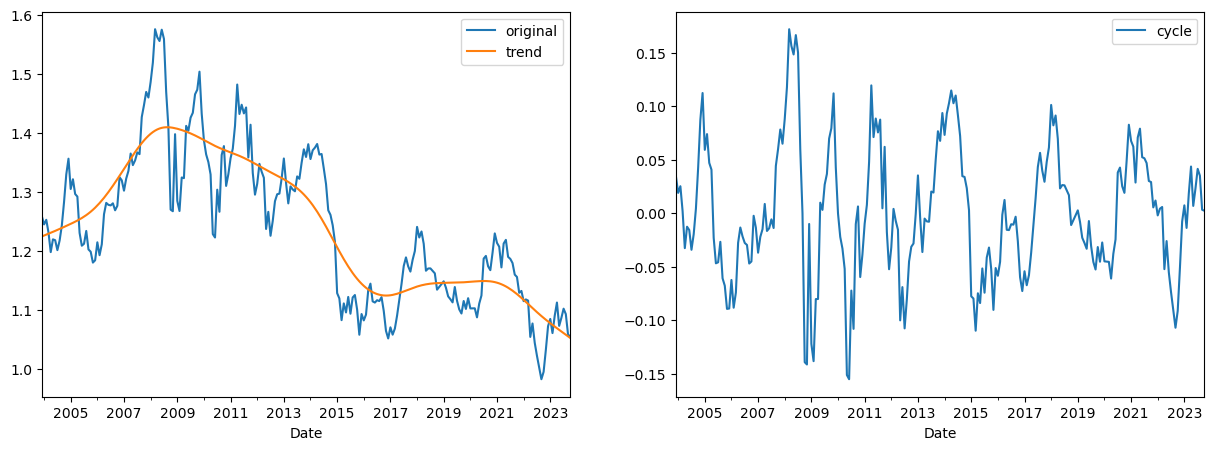

In [28]:
figure, axes = plt.subplots(ncols=2, figsize=(15,5))
df[["original", "trend"]].plot(ax=axes[0])
df[["cycle"]].plot(ax=axes[1])

In [29]:
%load_ext version_information
%version_information pandas, numpy, scipy, matplotlib, yfinance

Software versions
Python 3.10.9 64bit [MSC v.1916 64 bit (AMD64)]
IPython 8.10.0
OS Windows 10 10.0.22621 SP0
pandas 1.5.3
numpy 1.23.5
scipy 1.10.0
matplotlib 3.7.0
yfinance 0.2.31
Mon Oct 09 10:19:34 2023 Hora est. Pacífico, Sudamérica